In [ ]:
import numpy as np
import math
import matplotlib.ticker as ticker


def make_parity_plot_colorful(data, data_description, ax, plot_lim='largest_kgh'):
    """
    :param data: processed data to be plotted
    :param data_description: dictionary with descriptions of data used for plot annotations
    :param ax: subplot ax to plot on
    :param plot_lim: limit of x and y axes
    :return: ax: is the plotted parity chart
    """

    # Stage key for blinded status
    stage_description = {
        1: 'Fully blinded results',
        2: 'Unblinded wind',
        3: 'Partially unblinded',
    }
    ############ Data Preparation and Linear Regression ############

    # Load data description
    operator = data_description['operator']
    stage = data_description['stage']
    time_ave = data_description['time_ave']
    gas_comp_source = data_description['gas_comp_source']
    strict_discard = data_description['strict_discard']
    # legend_error = data_description['legend_error']

    # all data for linear regression 
    x_data = data.release_rate
    y_data = data.operator_report
    x_error = data.release_sigma * 1.96  # value is sigma, multiply by 1.96 for 95% CI
    y_error = data.operator_sigma  # error bars are determined in get_parity_data function

    # Fit linear regression via least squares with numpy.polyfit
    # m is slope, intercept is b
    m, b = np.polyfit(x_data, y_data, deg=1)

    # Calculate R^2 value
    # (using method described here: https://www.askpython.com/python/coefficient-of-determination)
    correlation_matrix = np.corrcoef(x_data, y_data)
    correlation = correlation_matrix[0, 1]
    r2 = correlation ** 2

    # Number of valid overpasses:
    sample_size = len(y_data)

    # Set x and y max values
    # Manually set largest x and y value by changing largest_kgh here to desired value:
    # largest_kgh = max(plot_lim)

    if plot_lim == 'largest_kgh':
        # Filter out NA because operations with NA returns NA
        if np.isnan(max(y_error)) == 1:
            y_error.iloc[:] = 0

        largest_kgh = max(max(x_data), max(y_data)) + max(y_error)
        largest_kgh = math.ceil(largest_kgh / 100) * 100

        # set plot_lim:
        plot_lim = [0, largest_kgh]
    else:
        largest_kgh = max(plot_lim)

    # Create sequence of numbers for plotting linear fit (x)
    x_seq = np.linspace(0, largest_kgh, num=100)

    ############ Generate Figure  ############

    # Add linear regression to in put ax
    ax.plot(x_seq, m * x_seq + b, color='k', lw=2,
            label=f'Best Fit, $R^2 =$ {r2:0.2f}\n$y = {m:0.2f}x+{b:0.2f}$',
            )

    # Add parity line
    # With label:
    # ax.plot(x_seq, x_seq, color='k', lw=2, linestyle='--',
    #          label='Parity Line')
    # Without label:
    ax.plot(x_seq, x_seq, color='k', lw=2, linestyle='--')
    
    # Make datasets for the blinded and unblinded data 
    
    # Break out data that was blinded vs unblinded in Phase III 
    data_unblinded = data[data['phase_iii'] == 1]
    data_blinded = data[data['phase_iii'] == 0]
    
    # Unblinded data in Phase III (ie excluded from Phase III) 
    x_data_unblinded = data_unblinded.release_rate
    y_data_unblinded = data_unblinded.operator_report
    x_error_unblinded = data_unblinded.release_sigma * 1.96  # value is sigma, multiply by 1.96 for 95% CI
    y_error_unblinded = data_unblinded.operator_sigma  # error bars are determined in get_parity_data function
    
    # Blinded data in Phase III (ie excluded from Phase III) 
    x_data_blinded = data_blinded.release_rate
    y_data_blinded = data_blinded.operator_report
    x_error_blinded = data_blinded.release_sigma * 1.96  # value is sigma, multiply by 1.96 for 95% CI
    y_error_blinded = data_blinded.operator_sigma  # error bars are determined in get_parity_data function

    # Unblinded data: add scatter plots with error bars
    
    # unblined sample size: 
    unblinded_sample_size = len(y_data_unblinded)
    unblinded_color = '#ff7f0e'
    ax.errorbar(x_data_unblinded, y_data_unblinded,
                xerr=x_error_unblinded,
                yerr=y_error_unblinded,
                linestyle='none',
                mfc='white',
                label=f'n = {unblinded_sample_size} (unblinded in Stage 3)',
                fmt='o',
                markersize=5, 
                color=unblinded_color,
                ecolor=unblinded_color)
    
    # Blinded data: add scatter plots with error bars
    blinded_sample_size = len(y_data_blinded)
    blinded_color = '#1f77b4'
    ax.errorbar(x_data_blinded, y_data_blinded,
                xerr=x_error_blinded,
                yerr=y_error_blinded,
                linestyle='none',
                mfc='white',
                color=blinded_color,
                label=f'n = {blinded_sample_size} (blinded in Stage 3)',
                fmt='o',
                markersize=5,
                ecolor=blinded_color)

    stage_text = stage_description[stage]
    # Set title
    ax.set_title(f'{operator} ({stage_text})')

    # ax.text(100, largest_kgh-100, f'{operator} ({stage_text})', fontsize=15, horizontalalignment='left',
    #          bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))

    # Annotation box
    # text = f'{operator}\n {stage_text}'
    # ob = offsetbox.AnchoredText(text, loc='upper left')
    # ob.set(alpha=0.8)
    # ax.add_artist(ob)

    # Set axes
    ax.set(xlim=plot_lim,
           ylim=plot_lim,
           alpha=0.8)

    # Equalize Axes
    ax.set_aspect('equal', adjustable='box')

    # Set axes and background color to white
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')

    # Axes labels
    # ax.set_xlabel('Methane Release Rate (kgh)', fontsize=14)
    # ax.set_ylabel('Reported Release Rate (kgh)', fontsize=14)
    ax.tick_params(direction='in', right=True, top=True)
    ax.tick_params(labelsize=16)
    ax.minorticks_on()
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    ax.tick_params(direction='in', which='minor', length=3, bottom=True, top=True, left=True, right=True)
    ax.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)
    ax.grid(False)  # remove grid lines

    # Customize the tick labels with commas at the thousands place
    ax.tick_params(labelsize=16)

    # Define a formatter function to add commas
    def comma_formatter(x, pos):
        return '{:,.0f}'.format(x)  # Add commas to the thousands place

    # Apply the formatter to the tick labels
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))

    # Legend
    ax.legend(facecolor='white', loc='lower right', fontsize=11)

    return ax


In [ ]:
import pathlib

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
from plot_methods import get_parity_data, make_parity_plot

#Phase 1 data 
cm_1_data, cm_1_notes = get_parity_data('Carbon Mapper', stage = 1)
ghg_1_data, ghg_1_notes = get_parity_data('GHGSat-AV', stage = 1)
kairos_1_data, kairos_1_notes = get_parity_data('Kairos', stage = 1)

# Phase 3 data
cm_3_data, cm_3_notes = get_parity_data('Carbon Mapper', stage = 3)
ghg_3_data, ghg_3_notes = get_parity_data('GHGSat-AV', stage = 3)
kairos_3_data, kairos_3_notes = get_parity_data('Kairos', stage=3)


axes_max = 2300

# # Set up figure - use smaller grid for now 
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6]] = plt.subplots(2,3, figsize=[21,14])
# 

# Phase 1 data
ax1 = make_parity_plot_colorful(cm_1_data, cm_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot_colorful(ghg_1_data, ghg_1_notes, ax2, [0, axes_max])
ax3 = make_parity_plot_colorful(kairos_1_data, kairos_1_notes, ax3, [0, axes_max])

# Phase 3 data 
ax4 = make_parity_plot(cm_3_data, cm_3_notes, ax4, [0, axes_max])
ax5 = make_parity_plot(ghg_3_data, ghg_3_notes, ax5, [0, axes_max])
ax6 = make_parity_plot(kairos_3_data, kairos_3_notes, ax6, [0, axes_max])

# Add common x-axis
txt_x_label = fig.text(0.5, 0.06, 'Release Rate (kg / hr)', ha='center', va='bottom', fontsize=20)

# Add common y-axis
txt_y_label_left = fig.text(0.07, 0.25, 'Operator Quantification Estimate (kg / hr)', rotation = 'vertical', ha='center', va='bottom', fontsize=20)



save_path = pathlib.PurePath('04_figures', '02_sahar_peer_review', f'test_plot_colors_phase1_3')
plt.savefig(save_path)
# display(cm_1_data_phase3_blind)

In [ ]:
# Plot Kairos wind normalized lower detection limit

from methods_source import load_overpass_summary, load_operator_report_dictionary, abbreviate_op_name
from plot_methods import rand_jitter
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
import pathlib
import matplotlib.ticker as ticker



def plot_wind_normalized_MDL(ax, annotation_text, operator, stage, n_bins, threshold, strict_discard=False, time_ave=60, gas_comp_source='ms'):
    # Load overpass summary for operator, stage, and discard criteria:
    operator_df = load_overpass_summary(operator, stage, strict_discard, time_ave, gas_comp_source)
    op_ab = abbreviate_op_name(operator)


    # load Kairos' clean data report
    report_dictionary = load_operator_report_dictionary()
    operator_report = report_dictionary[f'{op_ab}_{stage}']

    operator_df['windspeed'] = operator_report['OperatorWindspeed']

    wind_normalized = []
    for index, row in operator_df.iterrows():
        if row['operator_quantification'] == 0:
            kgh_per_mps = 0
        else:
            kgh_per_mps = row['operator_quantification'] / row['windspeed']
        wind_normalized.append(kgh_per_mps)

    operator_df['operator_kgh_per_mps'] = wind_normalized

    # Apply QC filter
    # For SI: Carbon Mapper's QC for determining quantification only, and treat their detection column as applied to all points

    # if (operator == 'Carbon Mapper') or (operator == 'Scientific Aviation'):
    #     operator_df = operator_df[(operator_df.stanford_kept == 1)]
    if (operator == 'Scientific Aviation'):
        # Scientific Aviation explicitly stated that all data could be used in determining detection, their QC only
        # applied to quantification
        operator_df = operator_df[(operator_df.stanford_kept == 1)]
    else:
        operator_df = operator_df[(operator_df.qc_summary == 'pass_all')]

    # Must be non-zero values
    operator_df = operator_df.query('non_zero_release == True')

    # Select release under threshold value
    operator_df = operator_df.query('operator_kgh_per_mps <= @threshold')

    # Create bins for plot
    bins = np.linspace(0, threshold, n_bins + 1)
    detection_probability = np.zeros(n_bins)

    # These variables are for keeping track of values as I iterate through the bins in the for loop below:
    bin_size, bin_num_detected = np.zeros(n_bins).astype('int'), np.zeros(n_bins).astype('int')
    bin_median = np.zeros(n_bins)
    bin_two_sigma = np.zeros(n_bins)
    two_sigma_upper, two_sigma_lower = np.zeros(n_bins), np.zeros(n_bins)

    # For each bin, find number of data points and detection probability

    for i in range(n_bins):

        # Set boundary of bin
        bin_min = bins[i]
        bin_max = bins[i + 1]
        bin_median[i] = (bin_min + bin_max) / 2

        # Select data within the bin range
        binned_data = operator_df.loc[operator_df.operator_kgh_per_mps < bin_max].loc[
            operator_df.operator_kgh_per_mps >= bin_min]

        # Count the total number of overpasses detected within each bin
        bin_num_detected[i] = binned_data.operator_detected.sum()

        n = len(binned_data)
        bin_size[i] = n  # this is the y-value for the bin in the plot
        p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows
        detection_probability[i] = p

        # Standard Deviation of a binomial distribution
        sigma = np.sqrt(p * (1 - p) / n)
        bin_two_sigma[i] = 2 * sigma

        # Find the lower and upper bound defined by two sigma
        two_sigma_lower[i] = 2 * sigma
        two_sigma_upper[i] = 2 * sigma
        if 2 * sigma + p > 1:
            two_sigma_upper[i] = 1 - p  # probability cannot exceed 1
        if p - 2 * sigma < 0:
            two_sigma_lower[i] = p  # if error bar includes zero, set lower bound to p?

    detection_prob = pd.DataFrame({
        "bin_median": bin_median,
        "detection_prob_mean": detection_probability,
        "detection_prob_two_sigma_upper": two_sigma_upper,
        "detection_prob_two_sigma_lower": two_sigma_lower,
        "n_data_points": bin_size,
        "n_detected": bin_num_detected})

    # Function will output cm_detection and detection_prob

    detection_plot = detection_prob.copy()
    # fig, ax = plt.subplots(1, figsize=(6, 6))

    # Set bin width:
    w = threshold / n_bins / 2.5

    # Use n_bins set above
    for i in range(n_bins):
        ax.annotate(f'{detection_plot.n_detected[i]} / {detection_plot.n_data_points[i]}',
                    [detection_plot.bin_median[i] - w / 1.8, 0.03], fontsize=10)

    # for plotting purpose, we don't want a small hyphen indicating zero uncertainty interval
    detection_plot.loc[detection_plot['detection_prob_two_sigma_lower'] == 0, 'detection_prob_two_sigma_lower'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_two_sigma_upper == 0, 'detection_prob_two_sigma_upper'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_mean == 0, 'detection_prob_mean'] = np.nan

    # To avoid RuntimeWarning: All-NaN axis encountered, set yerr to None if all values are np.nan in sigma values
    # (this is the case for Carbon Mapper)

    sigma_lower = detection_plot.detection_prob_two_sigma_lower
    sigma_upper = detection_plot.detection_prob_two_sigma_upper

    if sigma_lower.isnull().all() or sigma_upper.isnull().all():
        y_error = None
    else:
        y_error = [sigma_lower, sigma_upper]

    if threshold > n_bins:
        col_width = threshold / n_bins - 0.5
    else:
        col_width = threshold / n_bins - 0.1 # 0.1 chosen because this is what looks good with 5 kgh/mps threshold

    # Plot bars and detection points
    ax.bar(detection_plot.bin_median,
           detection_plot.detection_prob_mean,
           # yerr=[detection_plot.detection_prob_two_sigma_lower, detection_plot.detection_prob_two_sigma_upper],
           yerr=y_error,
           error_kw=dict(lw=2, capsize=3, capthick=1, alpha=0.3),
           width=col_width, alpha=0.6, color='#9ecae1', ecolor='black', capsize=2)

    # yulia's color: edgecolor="black",facecolors='none'
    x_data = rand_jitter(operator_df.operator_kgh_per_mps)

    ax.scatter(x_data, np.multiply(operator_df.operator_detected, 1),
               facecolors='black',
               marker='|')


    # Axes formatting and labels
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=11)
    ax.set_xlabel('Methane Release Rate (kgh/mps)', fontsize=14)
    ax.set_ylabel('Proportion detected', fontsize=14)
    ax.tick_params(direction='in', right=True, top=True)
    ax.tick_params(labelsize=12)
    ax.minorticks_on()
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    ax.tick_params(direction='in', which='minor', length=3, bottom=False, top=False, left=True, right=True)
    ax.tick_params(direction='in', which='major', length=6, bottom=True, top=False, left=True, right=True)

    # Set axes and background color to white
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')

    # Set more room on top for annotation
    ax.set_ylim([-0.05,1.22])
    ax.set_xlim([0,threshold])
    ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
    ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=11)
    ax.annotate(annotation_text, xy=(0.03, 0.89), xycoords='axes fraction', fontsize=11)


    # plt.title(f'{operator} Probability of Detection - Stage {stage}')

    # Save figure

    if strict_discard == True:
        discard = 'strict'
    else:
        discard = 'lax'

    # now = datetime.datetime.now()
    # save_time = now.strftime("%Y%m%d")
    # op_ab = abbreviate_op_name(operator)
    # fig_name = f'detect_limit_{op_ab}_stage{stage}_{discard}_{save_time}'
    # fig_path = pathlib.PurePath('04_figures', '01_paper_figs', fig_name)
    # plt.savefig(fig_path)
    # plt.show()

    #return operator_df, detection_prob
    return ax

# kairos_df, kairos_detection = plot_wind_normalized_MDL('Kairos', 1, 5, 25, strict_discard=False, time_ave=60, gas_comp_source='ms')

stage = 1
discard = 'lax'

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[15, 5])

ax1_annotate = 'Carbon Mapper wind normalized data\n(Fully blinded results)'
ax2_annotate = 'GHGSat wind normalized data\n(Fully blinded results) '
ax1 = plot_wind_normalized_MDL(ax1, ax1_annotate,  'Carbon Mapper', 1, 10, 30, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax2 = plot_wind_normalized_MDL(ax2, ax2_annotate, 'GHGSat-AV', 1, 10, 30, strict_discard=False, time_ave=60, gas_comp_source='ms')
# Set minor tick marks below y=1
minor_ticks = np.arange(0.1, 1.0, 0.05)  # Minor tick positions below y=1
ax1.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
ax2.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
fig_name = f'ghgsat+cm_pod_stage{stage}_{discard}_{save_time}'
fig_path = pathlib.PurePath('04_figures', '02_sahar_peer_review', fig_name)
plt.savefig(fig_path)
plt.show()
# kairos_overpasses = load_overpass_summary(operator='Kairos', strict_discard=False, stage=1)
#
# # load Kairos' clean data report
# report_dictionary = load_operator_report_dictionary()
# operator_report = report_dictionary['kairos_1']
#
# kairos_overpasses['windspeed'] = operator_report['OperatorWindspeed']
# kairos_overpasses['operator_kgh_per_mps'] = kairos_overpasses['operator_quantification'] / kairos_overpasses['windspeed']

Figure saved


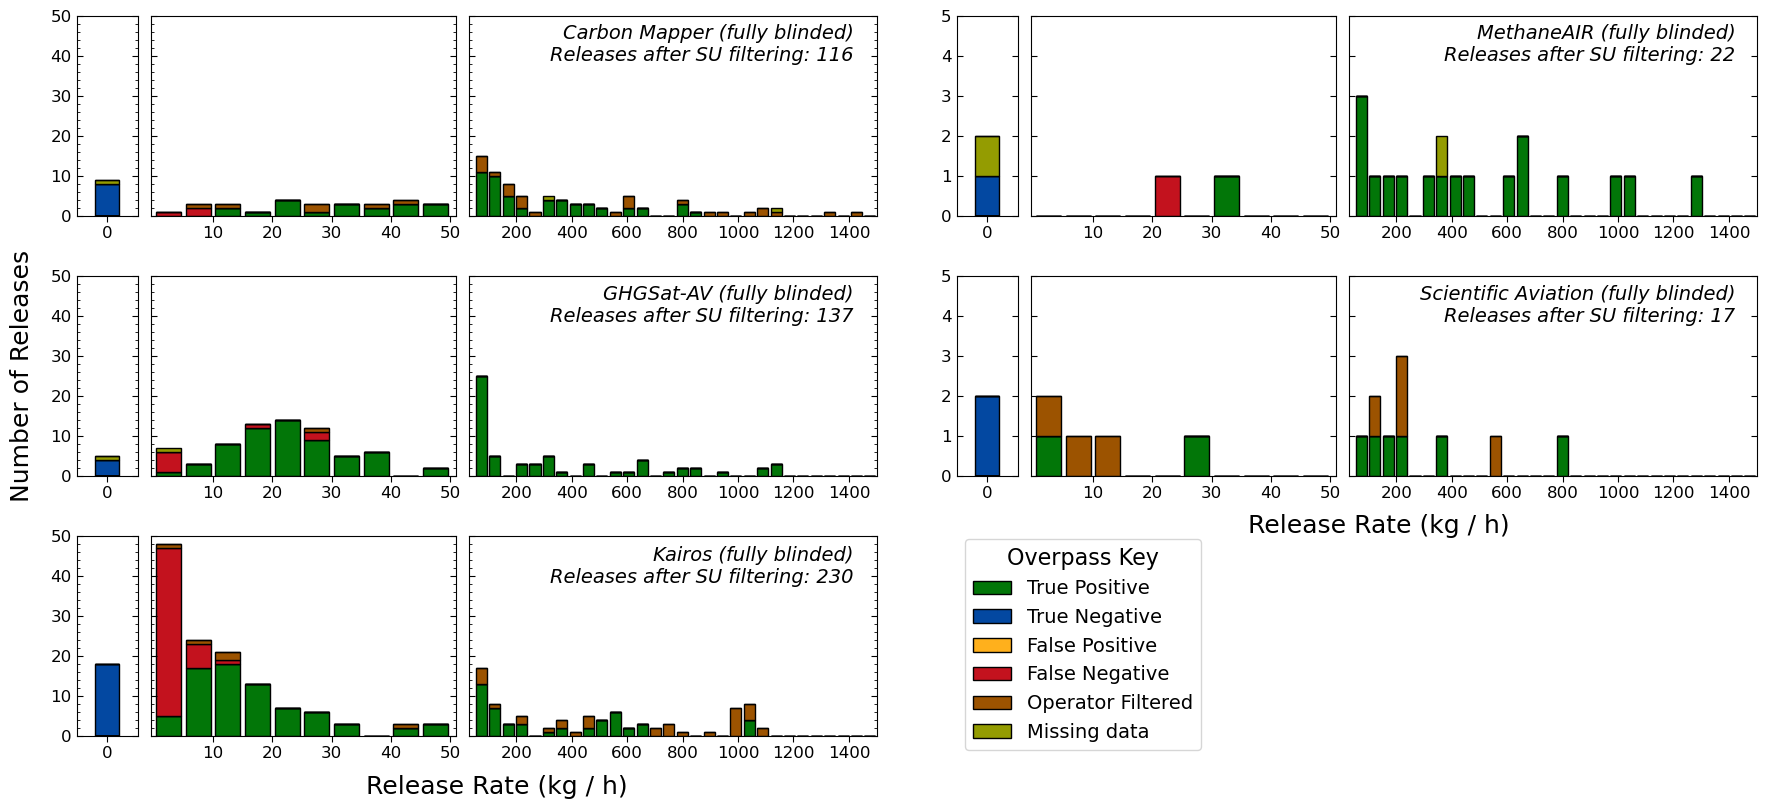

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from methods_source import classify_histogram_data, abbreviate_op_name
from matplotlib.patches import Patch
import datetime
import pathlib

def make_releases_histogram_subplot(ax1, ax2, ax3, operator, stage, strict_discard=False, time_ave=60, gas_comp_source='ms'):
    """

    :param ax1: subplot for displaying zero releases
    :param ax2: subplot for displaying mid-range (0 to 50 kgh)
    :param ax3: subplot for displaying high range (50 to 1600 kgh)
    :param operator: name of operator
    :param stage: stage of anlaysis (1, 2, 3)
    :param strict_discard: Boolean, False is default value
    :param time_ave: time average period for meter data (60s is default)
    :param gas_comp_source: source for gas compositional analysis, default value is measurement station ('ms')
    :return ax1: subplot with zero releases
    :return ax2: subplot with mid-range releases
    :return ax3: subplot with high range releases
    """
    ############## Setup Data ##############
    
    # track total number of releases 
    total_releases = 0 

    # Create bins for middle histogram plot
    threshold_lower = 0
    threshold_upper = 50
    n_bins = 10
    op_histogram_low = classify_histogram_data(operator=operator, stage=stage,
                                               threshold_lower=threshold_lower, threshold_upper=threshold_upper,
                                               n_bins=n_bins,
                                               strict_discard=strict_discard, time_ave=time_ave,
                                               gas_comp_source=gas_comp_source)

    # Create bins for right histogram plot
    threshold_lower = 50
    threshold_upper = 1500
    n_bins = 30
    op_histogram_high = classify_histogram_data(operator=operator, stage=stage,
                                                threshold_lower=threshold_lower, threshold_upper=threshold_upper,
                                                n_bins=n_bins,
                                                strict_discard=strict_discard, time_ave=time_ave,
                                                gas_comp_source=gas_comp_source)

    ############## Figure ##############
    # fig, [ax1, ax2, ax3] = plt.subplots(1, 3,
    #                                     figsize=(10, 3),
    #                                     gridspec_kw={'width_ratios': [0.6, 3, 4]})

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.05,
                        hspace=0.05)

    # Determine max value for the y-axis
    # low_height = op_histogram_low.bin_height.max()
    # high_height = op_histogram_high.bin_height.max()
    # y_height = max(low_height, high_height)
    # y_height = math.ceil(y_height / 5) * 5

    # Hard code desired bin height for each operator
    op_ab = abbreviate_op_name(operator)
    bin_height_dict = {
        'cm': 50,
        'ghg': 50,
        'kairos': 50,
        'mair':5,
        'sciav':5,

    }
    y_height = bin_height_dict[op_ab]
    # Manually set y_height
    #y_height = 50

    # Ram's colors:
    seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
    #           0sangre,    1neptune,  2pumpkin,  3clover,  4denim,     5cocoa,     6cumin  7berry

    # Color scheme
    tp_color = seshadri[3]
    tn_color = seshadri[1]
    fp_color = seshadri[2]
    fn_color = seshadri[0]
    su_color = seshadri[4]
    op_color = seshadri[5]
    missing_color = seshadri[6]

    ####### Left histogram #######
    bar_width = 0.2
    # add true negatives
    ax1.bar(0, op_histogram_low.true_negative, width=bar_width, edgecolor='black', color=tn_color)

    # Zero release discarded by SU
    # su_filter_height0 = op_histogram_low.true_negative
    # ax1.bar(0, op_histogram_low.zero_filter_su, bottom=su_filter_height0, width=bar_width, label='Stanford Filtered',
    #         edgecolor='black', color=su_color)


    # Zero release discarded by operator
    op_filter_height0 = op_histogram_low.true_negative
    ax1.bar(0, op_histogram_low.zero_filter_op, bottom=op_filter_height0, width=bar_width, label='Operator Filtered',
            edgecolor='black', color=op_color)

    # Missing data zero release
    missing_height = np.add(op_filter_height0, op_histogram_low.zero_filter_op).tolist()
    ax1.bar(0, op_histogram_low.zero_missing, bottom=missing_height, width=bar_width, label='Missing',
            edgecolor='black', color=missing_color)

    # Add false positives
    false_positive_height = np.add(missing_height, op_histogram_low.zero_missing).tolist()
    ax1.bar(0, op_histogram_low.false_positive, bottom=false_positive_height, width=bar_width, label='False Positive',
            edgecolor='black', color=fp_color)
    
    total_releases = total_releases + op_filter_height0 + missing_height + false_positive_height

    ####### Middle histogram #######
    bar_width = 4.2
    # Middle plot

    # Add True Positives
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.true_positive, width=bar_width,
            label='True positive', edgecolor='black', color=tp_color)

    # Add False Positives
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.false_positive, bottom=op_histogram_low.true_positive,
            width=bar_width, label='False positive', edgecolor='black', color=fp_color)

    # Add False Negatives
    fn_height = np.add(op_histogram_low.true_positive, op_histogram_low.false_positive).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.false_negative, bottom=op_histogram_low.true_positive,
            width=bar_width, label='False Negative', edgecolor='black', color=fn_color)

    # Add Stanford QC
    # su_filter_height = np.add(fn_height, op_histogram_low.false_negative).tolist()
    # ax2.bar(op_histogram_low.bin_median, op_histogram_low.filter_stanford, bottom=su_filter_height, width=bar_width,
    #         label='Stanford Filtered', edgecolor='black', color=su_color)
    # su_filter_height = 0

    # Add Carbon Mapper QC
    op_filter_height = np.add(fn_height, op_histogram_low.false_negative).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.filter_operator, bottom=op_filter_height, width=bar_width,
            label='Operator Filtered', edgecolor='black', color=op_color)

    # Add missing data
    missing_height = np.add(op_filter_height, op_histogram_low.filter_operator).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.missing_data, bottom=missing_height, width=bar_width,
            label='Missing', edgecolor='black', color=missing_color)

    ####### Right plot #######

    # reset bin width
    bar_width = 40
    # Add True Positives
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.true_positive, width=bar_width, label='True positive',
            edgecolor='black', color=tp_color)

    # Add False Positives
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.false_positive, bottom=op_histogram_high.true_positive,
            width=bar_width, label='False positive', edgecolor='black', color=fp_color)

    # Add False Negatives
    fn_height = np.add(op_histogram_high.true_positive, op_histogram_high.false_positive).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.false_negative, bottom=op_histogram_high.true_positive,
            width=bar_width, label='False Negative', edgecolor='black', color=fn_color)

    # Add Stanford QC
    # su_filter_height = np.add(fn_height, op_histogram_high.false_negative).tolist()
    # ax3.bar(op_histogram_high.bin_median, op_histogram_high.filter_stanford, bottom=su_filter_height, width=bar_width,
    #         label='Stanford Filtered', edgecolor='black', color=su_color)

    # Add Carbon Mapper QC
    op_filter_height = np.add(fn_height, op_histogram_high.false_negative).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.filter_operator, bottom=op_filter_height, width=bar_width,
            label='Operator Filtered', edgecolor='black', color=op_color)

    # Add missing data
    missing_height = np.add(op_filter_height, op_histogram_high.filter_operator).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.missing_data, bottom=missing_height, width=bar_width,
            label='Missing', edgecolor='black', color=missing_color)

    ############ Plot formatting ############
    # Set height of x and y axis limits
    # Left plot only shows zero
    ax1.set_ylim(bottom=0, top=y_height)
    ax1.set_xlim([-0.25, 0.25])

    # Middle plot shows >0 to 50 kgh
    ax2.set_ylim(bottom=0, top=y_height)
    ax2.set_xlim(left=-0.5, right=51)

    # Right plot shows 50 to 1500
    ax3.set_ylim(bottom=0, top=y_height)
    ax3.set_xlim(left=30, right=1500)

    # Common label for x-axis on all suplots
    # txt_x_label = fig.text(0.5, -0.08, 'Release Rate (kgh)', ha='center', va='bottom', fontsize=14)

    # Plot title
    # remove stage for methane air
    #txt_title = fig.text(0.5, 1, f'{operator} Results Classification', ha='center', va='top', fontsize=15)

    # Axes formatting and labels

    # set common label font size:
    label_font_size = 12
    ax1.set_xticks([0])  # only have a tick at 0
    # ax1.set_ylabel('Number of Releases', fontsize=12) # remove this for now to check if I want a common axis
    ax1.tick_params(labelsize=label_font_size)
    ax1.minorticks_on()
    ax1.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)  # only label left & bottom axis
    ax1.tick_params(direction='in', which='major', axis='y', length=4, left=True, right=True)  # y-axis major
    # Turn off minor axis ticks for SciAv plot
    ax1.tick_params(direction='in', which='minor', length=2, left=True, right=True)  # y-axis minor
    ax1.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major

    # Format axes on middle plot
    ax2.tick_params(labelsize=label_font_size)
    ax2.minorticks_on()
    ax2.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=False)  # only label bottom axis
    ax2.tick_params(direction='in', which='major', axis='y', length=4, left=True, right=True)  # y-axis major

    # Turn off minor axis ticks for SciAv plot
    ax2.tick_params(direction='in', which='minor', length=2, left=True, right=True)  # y-axis minor
    ax2.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major
    ax2.tick_params(which='minor', axis='x', bottom=False, top=False)
    x_ticks = ax2.xaxis.get_major_ticks()
    x_ticks[1].label1.set_visible(False)  # remove label on x=0
    x_ticks[1].set_visible(False)

    # Format axes on right plot
    ax3.tick_params(labelsize=label_font_size)
    ax3.minorticks_on()
    ax3.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=False)  # only label on bottom
    ax3.tick_params(axis='y', which='major', direction='in', length=4, left=True, right=True)  # y-axis major
    # Turn off minor axis ticks for SciAv plot
    ax3.tick_params(axis='y', which='minor', direction='in', length=2, left=True, right=True)  # y-axis minor

    ax3.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major
    ax3.tick_params(which='minor', axis='x', bottom=False, top=False)

    # Set axes and background color to white
    ax1.set_facecolor('white')
    ax1.spines['top'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['right'].set_color('black')
    ax1.spines['bottom'].set_color('black')

    return ax1, ax2, ax3




import matplotlib.gridspec as gridspec

######### Set up Figure Space #########

# [[ax1, ax2, ax3, ax10, ax11, ax12],[ax4, ax5, ax6, ax13, ax14, ax15], [ax7, ax8, ax9, ax16, ax17, ax18]]

fig = plt.figure(figsize=[21, 9])
outer = gridspec.GridSpec(1, 2, width_ratios = [1, 1], wspace = 0.1)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec = outer[0], width_ratios=[0.6, 3, 4], wspace=0.05, hspace=0.3)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec = outer[1], width_ratios=[0.6, 3, 4], wspace=0.05, hspace=0.3)

# Set each ax to match a cell in the gridspace
# operators on left column
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4])
ax6 = plt.subplot(gs1[5])
ax7 = plt.subplot(gs1[6])
ax8 = plt.subplot(gs1[7])
ax9 = plt.subplot(gs1[8])


# operators in right column
ax10 = plt.subplot(gs2[0])
ax11 = plt.subplot(gs2[1])
ax12 = plt.subplot(gs2[2])
ax13 = plt.subplot(gs2[3])
ax14 = plt.subplot(gs2[4])
ax15 = plt.subplot(gs2[5])
ax16 = plt.subplot(gs2[6])
ax17 = plt.subplot(gs2[7])
ax18 = plt.subplot(gs2[8])


######### Make Histograms #########
ax1, ax2, ax3 = make_releases_histogram_subplot(ax1, ax2, ax3, operator='Carbon Mapper', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')

ax4, ax5, ax6 = make_releases_histogram_subplot(ax4, ax5, ax6, operator='GHGSat', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax7, ax7, ax9 = make_releases_histogram_subplot(ax7, ax8, ax9, operator='Kairos', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax10, ax11, ax12 = make_releases_histogram_subplot(ax10, ax11, ax12, operator='MethaneAIR', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax13, ax14, ax15 = make_releases_histogram_subplot(ax13, ax14, ax15, operator='Scientific Aviation', stage=1, strict_discard=True, time_ave=60, gas_comp_source='ms')
ax16.axis('off')
ax17.axis('off')
ax18.axis('off')


# Add legend

seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']

# Color scheme
tp_color = seshadri[3]
tn_color = seshadri[1]
fp_color = seshadri[2]
fn_color = seshadri[0]
su_color = seshadri[4]
op_color = seshadri[5]
missing_color = seshadri[6]

histogram_legend = {
    'True Positive': tp_color,
    'True Negative': tn_color,
    'False Positive': fp_color,
    'False Negative': fn_color,
    # 'Stanford Filtered': su_color,
    'Operator Filtered': op_color, # remove operator filter for Methane AIR
    'Missing data': missing_color,
}

legend_elements = [Patch(facecolor=v, edgecolor='black', label=k) for k, v in histogram_legend.items()]
# lgd = ax3.legend(title='Overpass Key', handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
lgd = fig.legend(title='Overpass Key', handles=legend_elements,
                 bbox_to_anchor=(0.14, -.17, 0.5, 0.5), fontsize=14, title_fontsize=16)

# Turn off minor ticks for MAIR and SciAV
small_scale_ax = [ax10, ax11, ax12, ax13, ax14, ax15]
for ax in small_scale_ax:
    ax.tick_params(axis='y', which='minor', direction='in', length=2, left=False, right=False)

# Add common x-axis
txt_x_label_left = fig.text(0.3, 0.03, 'Release Rate (kg / h)', ha='center', va='bottom', fontsize=18)
txt_x_label_right = fig.text(0.72, 0.32, 'Release Rate (kg / h)', ha='center', va='bottom', fontsize=18)

# Add common y-axis
txt_y_label_left = fig.text(0.074, 0.36, 'Number of Releases', rotation = 'vertical', ha='center', va='bottom', fontsize=18)

# Add text for each opertor
y_delta = 0.29
left_align = 0.47
right_col_align = 0.89

cm_mair_height = 0.85
ghg_sciav_height = cm_mair_height - y_delta
kairos_height = ghg_sciav_height - y_delta

font_size = 14
cm_label = fig.text(left_align, cm_mair_height, 'Carbon Mapper (fully blinded)\nReleases after SU filtering: 116', fontsize=font_size, style='italic', ha='right')
ghg_label = fig.text(left_align, ghg_sciav_height, 'GHGSat-AV (fully blinded)\nReleases after SU filtering: 137', fontsize=font_size, style='italic', ha='right')
kairos_label = fig.text(left_align, kairos_height, 'Kairos (fully blinded)\nReleases after SU filtering: 230', fontsize=font_size, style='italic', ha='right')
mair_label = fig.text(right_col_align, cm_mair_height, 'MethaneAIR (fully blinded)\nReleases after SU filtering: 22', fontsize=font_size, style='italic', ha='right')
sciav_label = fig.text(right_col_align, ghg_sciav_height, 'Scientific Aviation (fully blinded)\nReleases after SU filtering: 17', fontsize=font_size, style='italic', ha='right')

# Save Figure
now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '02_sahar_peer_review', f'combined_histograms_horizontal_{save_time}')
plt.savefig(save_path)
print('Figure saved')


In [ ]:
display(classify_histogram_data(operator='Carbon Mapper', stage=1, threshold_lower=0, threshold_upper=3000, strict_discard=False, n_bins=1))

In [31]:
from writing_analysis import print_overpass_info
from methods_source import find_missing_data


def histogram_data_summary(operator, strict_discard=False):
    """ Function for generating the data used in operator overview paragraphs of Results section"""
    op_ab = abbreviate_op_name(operator)
    overpasses = load_overpass_summary(operator=operator, strict_discard=strict_discard, stage=1)
    missing = find_missing_data(operator)
    total_overpasses = len(missing) + len(overpasses)
    
    print(f'Operator: {operator}')
    print(f'Total number of overpasses: {total_overpasses}')
    su_filter = overpasses.loc[overpasses.stanford_kept == False]
    total_minus_SU_filter = total_overpasses - len(su_filter)
    print(f'Total number of overpasses after Stanford filtering: {total_minus_SU_filter}')
    print(f'Total number of missing releases: {len(missing)}\n')


histogram_data_summary('Carbon Mapper')
histogram_data_summary('GHGSat-AV')
histogram_data_summary('Kairos')
histogram_data_summary('MethaneAIR')
histogram_data_summary('Scientific Aviation', strict_discard=True)


Operator: Carbon Mapper
Total number of overpasses: 124
Total number of overpasses after Stanford filtering: 116
Total number of missing releases: 3

Operator: GHGSat-AV
Total number of overpasses: 194
Total number of overpasses after Stanford filtering: 137
Total number of missing releases: 2

Operator: Kairos
Total number of overpasses: 349
Total number of overpasses after Stanford filtering: 230
Total number of missing releases: 0

Operator: MethaneAIR
Total number of overpasses: 26
Total number of overpasses after Stanford filtering: 22
Total number of missing releases: 2

Operator: Scientific Aviation
Total number of overpasses: 18
Total number of overpasses after Stanford filtering: 17
Total number of missing releases: 0


In [ ]:
# This is the code I copied from 11_paper_figures.ipynb 

import pathlib

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
from plot_methods import get_parity_data, make_parity_plot

#TODO clean up this entire notebook
cm_1_data, cm_1_notes = get_parity_data('Carbon Mapper', stage = 1)
cm_2_data, cm_2_notes = get_parity_data('Carbon Mapper', stage = 2)
cm_3_data, cm_3_notes = get_parity_data('Carbon Mapper', stage = 3)
ghg_1_data, ghg_1_notes = get_parity_data('GHGSat-AV', stage = 1)
ghg_2_data, ghg_2_notes = get_parity_data('GHGSat-AV', stage = 2)
ghg_3_data, ghg_3_notes = get_parity_data('GHGSat-AV', stage = 3)
kairos_1_data, kairos_1_notes = get_parity_data('Kairos', stage=1)
kairos_2_data, kairos_2_notes = get_parity_data('Kairos', stage=2)
kairos_3_data, kairos_3_notes = get_parity_data('Kairos', stage=3)
mair_1_data, mair_1_notes = get_parity_data('Methane Air', stage=1)
sciav_1_data, sciav_1_notes = get_parity_data('Scientific Aviation', stage=1, strict_discard=True)

fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])

# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.05, hspace=0.18)  # Modify the values as needed

# Set axes
axes_max = 2300
# Carbon Mapper
ax1 = make_parity_plot(cm_1_data, cm_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot(cm_2_data, cm_2_notes, ax2, [0, axes_max])
ax3 = make_parity_plot(cm_3_data, cm_3_notes, ax3, [0, axes_max])

print('Making GHGSat plots...')
# GHGSat
ax4 = make_parity_plot(ghg_1_data, ghg_1_notes, ax4, [0, axes_max])
ax5 = make_parity_plot(ghg_2_data, ghg_2_notes, ax5, [0, axes_max])
ax6 = make_parity_plot(ghg_3_data, ghg_3_notes, ax6, [0, axes_max])

print('Making Kairos plots...')
# Kairos
ax7 = make_parity_plot(kairos_1_data, kairos_1_notes, ax7, [0, axes_max])
ax8 = make_parity_plot(kairos_2_data, kairos_2_notes, ax8, [0, axes_max])
ax9 = make_parity_plot(kairos_3_data, kairos_3_notes, ax9, [0, axes_max])

# MethaneAIR
print('Making MethaneAIR plots...')

ax10 = make_parity_plot(mair_1_data, mair_1_notes, ax10, [0, axes_max])

# Scientific Aviation
ax11 = make_parity_plot(sciav_1_data, sciav_1_notes, ax11, [0, axes_max])

# Turn off last axes
ax12.axis('off')

######## Figure Annotations ########

# # Add a large horizontal line above the bottom row
# line = Line2D([0.08, 0.94], [0.29, 0.29], color='black', transform=fig.transFigure, linewidth=3)
# fig.add_artist(line)

# Add common x-axis
txt_x_label = fig.text(0.5, 0.08, 'Release Rate (kg / hr)', ha='center', va='bottom', fontsize=20)

# Add common y-axis
txt_y_label_left = fig.text(0.08, 0.4, 'Operator Quantification Estimate (kg / hr)', rotation = 'vertical', ha='center', va='bottom', fontsize=20)


# Save figure
now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '02_sahar_peer_review', f'fig_3_colors_{save_time}')
plt.savefig(save_path)
print('Figure saved')

In [55]:
# Daily wind conditions summary 

from methods_source import summarize_wind_conditions
import datetime

# CM: 

cm_day1_start = datetime.datetime(2022, 10, 10, 16, 59, 00)
cm_day2_start = datetime.datetime(2022, 10, 11, 17, 14, 13)
cm_day3_start = datetime.datetime(2022, 10, 12, 17, 13, 16)
cm_day4_start = datetime.datetime(2022, 10, 28, 17, 49, 5)
cm_day5_start = datetime.datetime(2022, 10, 29, 17, 11, 30)
cm_day6_start = datetime.datetime(2022, 10, 31, 17, 14, 46)

cm_day1_end = datetime.datetime(2022, 10, 10, 21, 30, 14)
cm_day2_end = datetime.datetime(2022, 10, 11, 21, 16, 36)
cm_day3_end = datetime.datetime(2022, 10, 12, 21, 15, 23)
cm_day4_end = datetime.datetime(2022, 10, 28, 21, 7, 0)
cm_day5_end = datetime.datetime(2022, 10, 29, 21, 11, 34)
cm_day6_end = datetime.datetime(2022, 10, 31, 21, 14, 22)

# Kairos 

kairos_day1_start = datetime.datetime(2022, 10, 24, 16, 44, 28)
kairos_day2_start = datetime.datetime(2022, 10, 25, 16, 34, 27)
kairos_day3_start = datetime.datetime(2022, 10, 26, 16, 36, 47)
kairos_day4_start = datetime.datetime(2022, 10, 27, 16, 35, 23)
kairos_day5_start = datetime.datetime(2022, 10, 28, 16, 39, 12)

kairos_day1_end = datetime.datetime(2022, 10, 24, 19, 48, 44)
kairos_day2_end = datetime.datetime(2022, 10, 25, 20, 33, 1)
kairos_day3_end = datetime.datetime(2022, 10, 26, 20, 40, 55)
kairos_day4_end = datetime.datetime(2022, 10, 27, 20, 14, 15)
kairos_day5_end = datetime.datetime(2022, 10, 28, 20, 39, 58)


#MAIR: 
mair_day1_start = datetime.datetime(2022, 10, 25, 16, 55, 47)
mair_day2_start = datetime.datetime(2022, 10, 29, 16, 23, 1)

mair_day1_end = datetime.datetime(2022, 10, 25, 20, 46, 41)
mair_day2_end = datetime.datetime(2022, 10, 29, 21, 2, 17)

# GHGSat-AV 

ghg_day1_start = datetime.datetime(2022, 10, 31, 17, 1, 58)
ghg_day2_start = datetime.datetime(2022, 11, 2, 16, 36, 30)
ghg_day3_start = datetime.datetime(2022, 11, 4, 16, 41, 19)
ghg_day4_start = datetime.datetime(2022, 11, 7, 19, 21, 44)

ghg_day1_end = datetime.datetime(2022, 10, 31, 20, 59, 3)
ghg_day2_end = datetime.datetime(2022, 11, 2, 18, 5, 2)
ghg_day3_end = datetime.datetime(2022, 11, 4, 20, 31, 59)
ghg_day4_end = datetime.datetime(2022, 11, 7, 22, 9, 39)

# SciAV 

sciav_day1_start = datetime.datetime(2022, 11, 8, 21, 35, 0)
sciav_day2_start = datetime.datetime(2022, 11, 10, 18, 0, 0)
sciav_day3_start = datetime.datetime(2022, 11, 11, 19, 0, 0)

sciav_day1_end = datetime.datetime(2022, 11, 8, 23, 55, 3)
sciav_day2_end = datetime.datetime(2022, 11, 10, 22, 1, 22)
sciav_day3_end = datetime.datetime(2022, 11, 11, 23, 39, 33)


# wind_test1 = summarize_wind_conditions(test_1, test_2)

# Carbon Mapper day 1 
wind_test1 = summarize_wind_conditions(cm_day1_start, cm_day1_end) # oct 10 
wind_test2 = summarize_wind_conditions(cm_day2_start, cm_day2_end) # oct 11 
wind_test3 = summarize_wind_conditions(cm_day3_start, cm_day3_end) # oct 12
wind_test4 = summarize_wind_conditions(kairos_day1_start, kairos_day1_end) # oct 24

# oct 25 - mair day 1, kairos day 2
wind_test5 = summarize_wind_conditions(kairos_day2_start, mair_day1_end)

# oct 26 - kairos day 3
wind_test6 = summarize_wind_conditions(kairos_day3_start, kairos_day3_end)

# oct 27 - kairos day 4
wind_test7 = summarize_wind_conditions(kairos_day4_start, kairos_day4_end)

# oct 28 - kairos day 5; CM day 4 
wind_test8 = summarize_wind_conditions(kairos_day5_start, cm_day4_end)

# oct 29 - CM day 5, MethaneAIR day 2
wind_test8 = summarize_wind_conditions(mair_day2_start, cm_day5_end)

# oct 31 - CM day 6, GHGSat day 1 
wind_test9 = summarize_wind_conditions(ghg_day1_start, cm_day6_end)

# nov 2 - ghgsat day 2 --> 2D sonic anemometer 
wind_test10 = summarize_wind_conditions(ghg_day2_start, ghg_day2_end)

# nov 10 - sciav day 2 

wind_test11 = summarize_wind_conditions(sciav_day2_start, sciav_day2_end)
wind_test12 = summarize_wind_conditions(sciav_day3_start, sciav_day3_end)

print(wind_test6)


Number of rows that were NA in the average period (2022-11-10 18:00:00 to 2022-11-10 22:01:22): 69
{'average_windspeed': 1.5996315023593308, 'average_winddirection': 156.5785978964991, 'stdev_windspeed': 0.826806533805037, 'stdev_winddirection': 79.80512374140841}
